In [ ]:
import kaggle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from textblob import TextBlob
kaggle.api.dataset_download_files("ddosad/ecommerce-customer-service-satisfaction", path=".", unzip=True)

Reading .csv file and converting to datetime

In [2]:
df = pd.read_csv('Customer_support_data.csv')
pd.set_option('display.max_columns', None)
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ","_")

df["issue_responded"] = pd.to_datetime(df["issue_responded"], format='%d/%m/%Y %H:%M')
df["issue_reported_at"] = pd.to_datetime(df["issue_reported_at"], format='%d/%m/%Y %H:%M')

df['issue_reported_hour'] = df["issue_reported_at"].dt.hour
df['issue_reported_weekday'] = df["issue_reported_at"].dt.day_of_week
df['issue_responded_hour'] = df["issue_responded"].dt.hour
df['issue_responded_weekday'] = df["issue_responded"].dt.day_of_week

# Creating columns for promoters and detractors
df['promoter'] = df['csat_score'].map(lambda x: 0 if x<4 else 1)
df['detractor'] = df['csat_score'].map(lambda x: 0 if x>=4 else 1)



## One-Hot Encoding ##

Encoding categorical features so we can create a correlation matrix

In [3]:
cat_cols = ['channel_name', 'category','sub-category','supervisor', 'manager', 'tenure_bucket','agent_shift']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=False)
df_encoded = df_encoded.map(lambda x: 0 if x is False else 1 if x is True else x)

# Selecting just numerical columns
df_numeric = df_encoded.select_dtypes(include=['number'])

#Creating a correlation matrix
corr_matrix = df_numeric.corr()


## Promoters Correlation with Categorical Variables ##
We cannot use Pearson correlation with categorical variables, therefore I hot-encoded categorical variables and visualized the top correlated variables with the created promoters column. The result shows that there is no specific value within categorical variables that correlates with the number of promoters an agent gets:

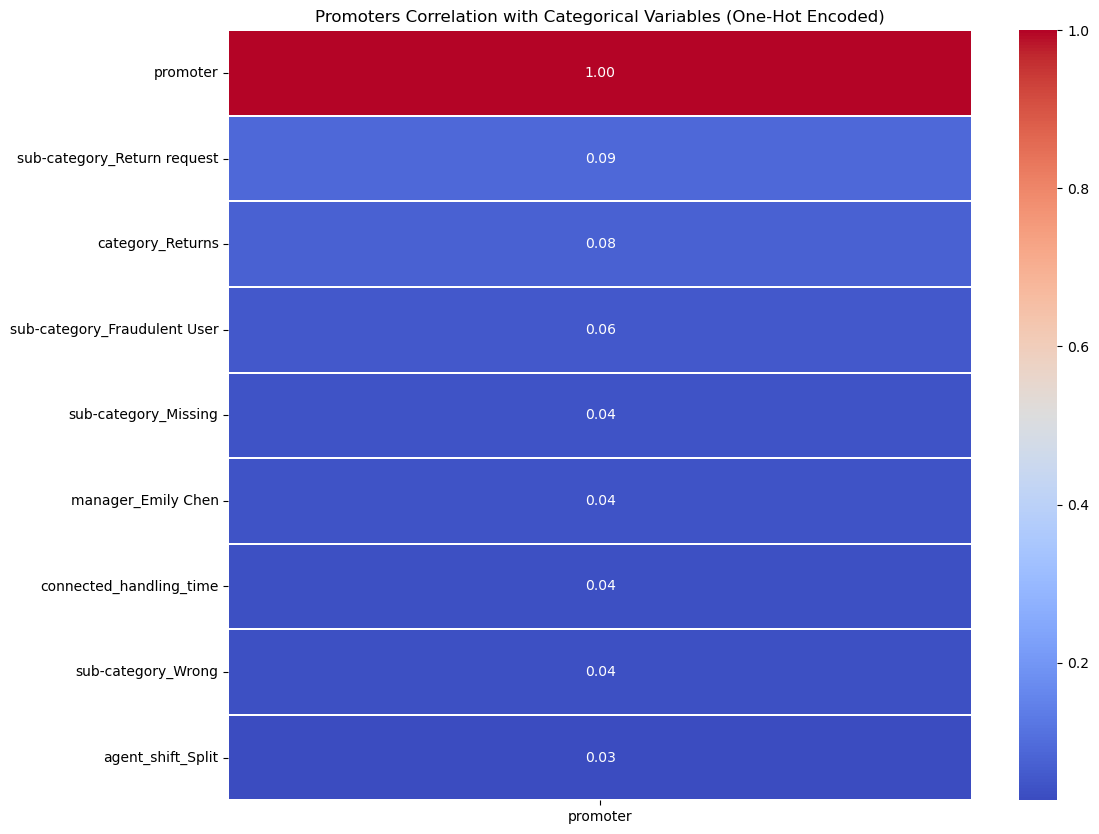

In [4]:
csat_corr = corr_matrix['promoter'].sort_values(ascending=False).to_frame()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix['promoter'].sort_values(ascending=False).to_frame().head(10).drop(index="csat_score"), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.1)
plt.title("Promoters Correlation with Categorical Variables (One-Hot Encoded)")
plt.show()

After plotting a correlation heatmap we can conclude that none of the categorical features have any correlation with promoters generation

## 3D Analysis | CSAT Score vs. Agent Tenure vs. Shift ##

In [5]:

# Converting agent shift to numerical categories
labelEncoder = LabelEncoder()
df['agent_shift_numeric'] = labelEncoder.fit_transform(df['agent_shift'])

# Converting agent tenure to numerical categories
tenures = ['On Job Training','0-30','31-60','61-90','>90']
ordinalEncoder = OrdinalEncoder(categories=[tenures])
df['agent_tenure_numeric'] = ordinalEncoder.fit_transform(df[['tenure_bucket']])

# Grouping by tenure bucket and shift type
df_3d = df.groupby(["tenure_bucket", "agent_shift"]).agg(
    promoters_sum=("promoter", "sum"),
    detractors_sum=("detractor", "sum")
).reset_index()
df_3d["csat_score"] = df_3d["promoters_sum"] / (df_3d["promoters_sum"] + df_3d["detractors_sum"])
df_3d

,tenure_bucket,agent_shift,promoters_sum,detractors_sum,csat_score
0,0-30,Afternoon,191,39,0.830435
1,0-30,Evening,3636,661,0.846172
2,0-30,Morning,5551,1240,0.817405
3,31-60,Afternoon,557,131,0.809593
4,31-60,Evening,4757,943,0.834561
5,31-60,Morning,4056,739,0.845881
6,31-60,Night,335,69,0.829208
7,31-60,Split,64,14,0.820513
8,61-90,Afternoon,597,98,0.858993
9,61-90,Evening,4007,712,0.849121


## 3D Bar Chart ##

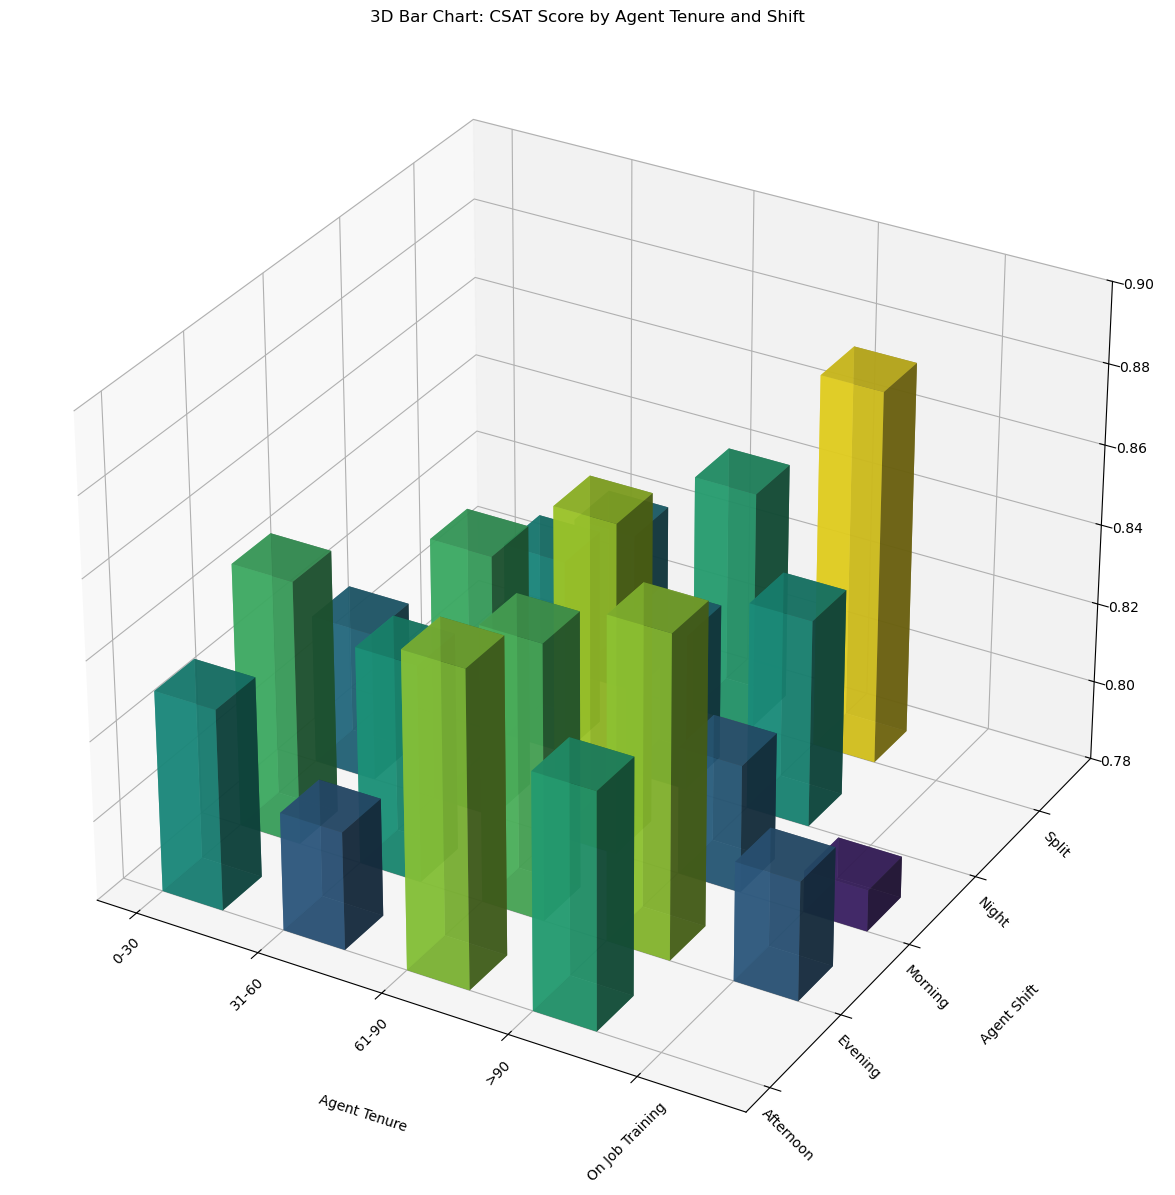

In [ ]:
# Defining base height and CSAT target
base_height = 0.78  
target_csat = 0.80 

# Mapping categorical variables to numerical values
tenure_labels = df_3d["tenure_bucket"].unique()
shift_labels = df_3d["agent_shift"].unique()

tenure_mapping = {label: i for i, label in enumerate(tenure_labels)}
shift_mapping = {label: i for i, label in enumerate(shift_labels)}

df_3d["tenure_numeric"] = df_3d["tenure_bucket"].map(tenure_mapping)
df_3d["shift_numeric"] = df_3d["agent_shift"].map(shift_mapping)

# Extracting data for plotting
x = df_3d["tenure_numeric"]
y = df_3d["shift_numeric"]
z = np.full(len(df_3d), base_height)  # Setting base height instead of 0.0
dx = dy = 0.5  # Bar width
dz = df_3d["csat_score"] - base_height  # Adjusting height relative to base

# Creating 3D figure
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

# Plotting 3D bars
colors = plt.cm.viridis(dz / max(dz))
ax.bar3d(x, y, z, dx, dy, dz, shade=True, alpha=0.8, color=colors)

# Setting labels
ax.set_xlabel("Agent Tenure", labelpad=35)
ax.set_ylabel("Agent Shift", labelpad=35)
ax.set_zlabel("CSAT Score", labelpad=35)

# Setting axis ticks to show original category names
ax.set_xticks(list(tenure_mapping.values()))
ax.set_xticklabels(tenure_labels, rotation=45)

ax.set_yticks(list(shift_mapping.values()))
ax.set_yticklabels(shift_labels, rotation= -45)

# Adjusting z-axis limits
ax.set_zlim(base_height, 0.9)  

plt.title("3D Bar Chart: CSAT Score by Agent Tenure and Shift")
plt.show()


After 3D plotting CSAT vs categorical variables like tenure and shift, there are no observable trends.

However, the split shift group showed a significant higher CSAT score than other shift types in the tenure agents, we need context in order to know if higher CSAT scores in this group are caused by a split shift, or if these agents were granted to have a split shift due to their higher performance, but definitely something to consider.

In [ ]:
# Checking if we have agents included in different categories to avoid duplicates
agentVariability = df.groupby('agent_name')[['supervisor', 'manager', 'tenure_bucket', 'agent_shift']].nunique()
agentsWithMultipleValues = agentVariability[agentVariability.gt(1).any(axis=1)]
agentsWithMultipleValues


,supervisor,manager,tenure_bucket,agent_shift
agent_name,,,,


# Preparing data for a model classifier #

In [18]:
df['response_time_hours'] = (df['issue_responded'] - df['issue_reported_at']).dt.total_seconds() / 3600
clusterDf = df[df['response_time_hours'] >= 0]
clusterDf = clusterDf[['agent_name','tenure_bucket', 'agent_shift', 'supervisor','manager','response_time_hours','category', 'csat_score']]

clusterDf = clusterDf.join(pd.get_dummies(clusterDf['tenure_bucket'], prefix='tenure_bucket')).drop('tenure_bucket', axis = 1)
clusterDf = clusterDf.join(pd.get_dummies(clusterDf['agent_shift'], prefix='agent_shift')).drop('agent_shift', axis = 1)
clusterDf = clusterDf.join(pd.get_dummies(clusterDf['supervisor'], prefix='supervisor')).drop('supervisor', axis = 1)
clusterDf = clusterDf.join(pd.get_dummies(clusterDf['manager'], prefix='manager')).drop('manager', axis = 1)
clusterDf = clusterDf.join(pd.get_dummies(clusterDf['category'], prefix='category')).drop('category', axis = 1)

# Mapping booleans to 0 and 1
clusterDf = clusterDf.map(lambda x: 0 if x is False else 1 if x is True else x)
clusterDf = clusterDf.drop(columns=['agent_name'])

# Dropping csat_score since we are going to train our classifier based on promoters/detractors, not score
clusterDf["is_promoter"] = clusterDf['csat_score'].map(lambda x: 1 if x>=4 else 0)
clusterDf = clusterDf.drop(columns=['csat_score'])

clusterDf

,response_time_hours,tenure_bucket_0-30,tenure_bucket_31-60,tenure_bucket_61-90,tenure_bucket_>90,tenure_bucket_On Job Training,agent_shift_Afternoon,agent_shift_Evening,agent_shift_Morning,agent_shift_Night,agent_shift_Split,supervisor_Abigail Suzuki,supervisor_Aiden Patel,supervisor_Alexander Tanaka,supervisor_Amelia Tanaka,supervisor_Austin Johnson,supervisor_Ava Wong,supervisor_Brayden Wong,supervisor_Carter Park,supervisor_Charlotte Suzuki,supervisor_Dylan Kim,supervisor_Elijah Yamaguchi,supervisor_Emily Yamashita,supervisor_Emma Park,supervisor_Ethan Nakamura,supervisor_Ethan Tan,supervisor_Evelyn Kimura,supervisor_Harper Wong,supervisor_Isabella Wong,supervisor_Jackson Park,supervisor_Jacob Sato,supervisor_Landon Tanaka,supervisor_Layla Taniguchi,supervisor_Lily Chen,supervisor_Logan Lee,supervisor_Lucas Singh,supervisor_Madison Kim,supervisor_Mason Gupta,supervisor_Mia Patel,supervisor_Mia Yamamoto,supervisor_Nathan Patel,supervisor_Noah Patel,supervisor_Oliver Nguyen,supervisor_Olivia Suzuki,supervisor_Olivia Wang,supervisor_Scarlett Chen,supervisor_Sophia Chen,supervisor_Sophia Sato,supervisor_William Park,supervisor_Wyatt Kim,supervisor_Zoe Yamamoto,manager_Emily Chen,manager_Jennifer Nguyen,manager_John Smith,manager_Michael Lee,manager_Olivia Tan,manager_William Kim,category_App/website,category_Cancellation,category_Feedback,category_Offers & Cashback,category_Onboarding related,category_Order Related,category_Others,category_Payments related,category_Product Queries,category_Refund Related,category_Returns,category_Shopzilla Related,is_promoter
0,0.566667,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0.033333,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0.366667,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0.333333,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0.033333,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85902,8.033333,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
85903,0.033333,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
85904,0.083333,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
85905,0.016667,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1


## Up-Sampling and Model Training

In [ ]:
X = clusterDf.drop(columns=['is_promoter'])
y = clusterDf['is_promoter']


# Up-sampling with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


# Splitting into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=42)

# Scaling since we have a continuous measure
scaleminmax = MinMaxScaler(feature_range=(0,1))
X_train = scaleminmax.fit_transform(X_train)
X_test = scaleminmax.fit_transform(X_test)

# Training the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train,y_train)

# Predicting
y_pred = rf.predict(X_test)

# Report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.73      0.73     13470
           1       0.74      0.73      0.73     13781

    accuracy                           0.73     27251
   macro avg       0.73      0.73      0.73     27251
weighted avg       0.73      0.73      0.73     27251



## Feature Importance ##

Getting the most important features of our model

In [ ]:
importance = rf.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns,'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance

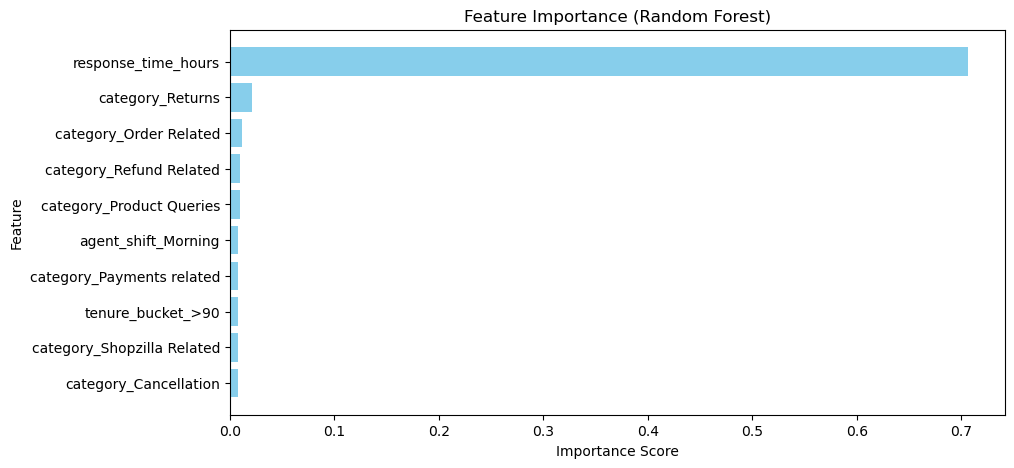

In [ ]:
# Plotting feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10), color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Flip to show most important first
plt.show()

## Checking if response time is indeed important ##

We need to verify whether "response time hours" is genuinely the most predictive feature trying a Permutation Feature Importance Test

In [ ]:
#Permutation Importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
feature_importance_perm = pd.DataFrame({'Feature': X.columns,'Importance': perm_importance.importances_mean})
feature_importance_perm = feature_importance_perm.sort_values(by='Importance', ascending=False)

Response time is still the most important feature after 10 permutations

In [50]:
feature_importance_perm

,Feature,Importance
0,response_time_hours,0.130439
67,category_Returns,0.085663
62,category_Order Related,0.040780
51,manager_Emily Chen,0.019342
7,agent_shift_Evening,0.019247
...,...,...
42,supervisor_Oliver Nguyen,0.000407
15,supervisor_Austin Johnson,0.000407
57,category_App/website,0.000228
61,category_Onboarding related,0.000073


## Plotting response time using bins ##

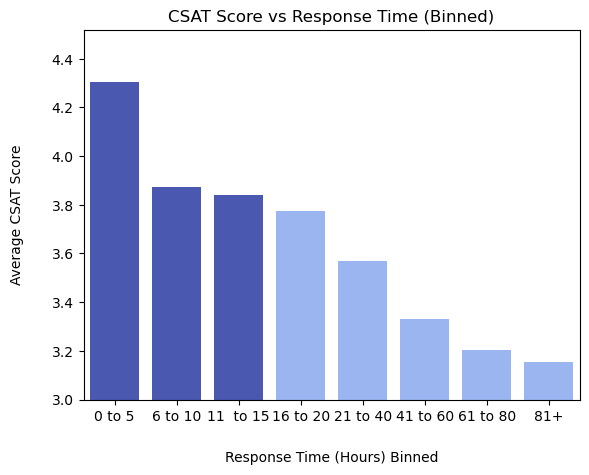

In [34]:
dffeatures = df[df['response_time_hours'] >= 0].copy()

bins = [0,5,10,15,20,40,60,80,100]
labels = ['0 to 5', '6 to 10', '11  to 15', '16 to 20', '21 to 40', '41 to 60', '61 to 80','81+']

dffeatures['response_time_group'] = pd.cut(dffeatures['response_time_hours'], bins=bins, labels=labels)

dffeaturesGroup = dffeatures.groupby('response_time_group', observed=False)['csat_score'].mean().reset_index()
dffeaturesGroup

plt.Figure(figsize=(10,5))
sns.barplot(data = dffeaturesGroup, x = 'response_time_group', y = 'csat_score', palette='coolwarm', hue=x, legend=False)
plt.ylim(3)
plt.xlabel("Response Time (Hours) Binned",labelpad=20)
plt.ylabel("Average CSAT Score",labelpad=20)
plt.title("CSAT Score vs Response Time (Binned)")
plt.show()

We can see how csat scores on average drop as agents take longer to respond to an issue

## Sentiment Analysis

In [38]:
# Filtering by surveys with remarks
remarksDf = df[df['customer_remarks'].notna()]
remarksDfFiltered = remarksDf[['customer_remarks','agent_name','category', 'sub-category', 'supervisor', 'manager','tenure_bucket','agent_shift', 'promoter', 'detractor']].copy()
remarksDfFiltered

,customer_remarks,agent_name,category,sub-category,supervisor,manager,tenure_bucket,agent_shift,promoter,detractor
7,Very good,Laura Smith,Returns,Exchange / Replacement,Evelyn Kimura,Jennifer Nguyen,On Job Training,Evening,1,0
8,Shopzilla app and it's all coustomer care serv...,David Smith,Returns,Missing,Nathan Patel,John Smith,>90,Split,1,0
11,Very bad,Stanley Hogan,Order Related,Delayed,Harper Wong,Emily Chen,>90,Split,0,1
17,Something,Jennifer May,Order Related,Installation/demo,Zoe Yamamoto,William Kim,On Job Training,Morning,0,1
19,All good,David Butler,Order Related,Installation/demo,Olivia Wang,Emily Chen,31-60,Evening,1,0
...,...,...,...,...,...,...,...,...,...,...
85887,If the customer care guy and their supervisors...,Robert Lara,Returns,Reverse Pickup Enquiry,Brayden Wong,John Smith,31-60,Evening,0,1
85888,Good my problem was solved,Morgan Floyd,Returns,Reverse Pickup Enquiry,Ethan Tan,William Kim,On Job Training,Morning,1,0
85896,Trough the Shopzilla App Refunding Policy shou...,Holly Huang,Payments related,Payment related Queries,Charlotte Suzuki,William Kim,On Job Training,Morning,1,0
85903,Supported team customer executive good,Linda Foster,Order Related,Seller Cancelled Order,Noah Patel,Emily Chen,>90,Morning,1,0


Defining our sentiment function using TextBlob:

In [39]:
def analyzeSentiment(text):
    if pd.isna(text) or text.strip() == "":
        return None
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [40]:
remarksDfFiltered['sentiment_score'] = remarksDfFiltered['customer_remarks'].apply(analyzeSentiment)

Mapping a sentiment category to our polarity result

In [41]:
# Categorize sentiment function
def categorizeSentiment(score):
    if score is None:
        return "Neutral"
    elif score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

remarksDfFiltered["sentiment_category"] = remarksDfFiltered['sentiment_score'].apply(categorizeSentiment).copy()

Counting each sentiment category

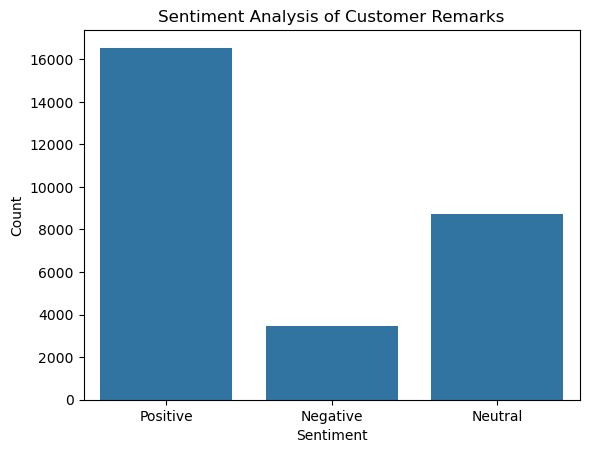

In [43]:
sns.countplot(data=remarksDfFiltered, x="sentiment_category")
plt.title("Sentiment Analysis of Customer Remarks")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In percentage terms:

In [44]:
sentimentBreakdown = remarksDfFiltered['sentiment_category'].value_counts().to_frame()
sentimentBreakdown['%'] = (remarksDfFiltered['sentiment_category'].value_counts() / remarksDfFiltered['sentiment_category'].value_counts().sum()) * 100
sentimentBreakdown

,count,%
sentiment_category,,
Positive,16542,57.553406
Neutral,8730,30.373669
Negative,3470,12.072925


Grouping by sentiment category to evaluate CSAT%:

There is a strong correlation between customer remarks sentiment and CSAT scores—92% of surveys with positive remarks result in a promoter rating.

In [28]:
surveysAndSentiment = remarksDfFiltered.groupby('sentiment_category').agg(
    promoters = ('promoter','sum'),
    surveys = ('promoter','count')
)
surveysAndSentiment['csat%'] = (surveysAndSentiment['promoters'] / surveysAndSentiment['surveys']) * 100
surveysAndSentiment.sort_values('csat%', ascending=False)

,promoters,surveys,csat%
sentiment_category,,,
Positive,15334,16542,92.697376
Neutral,5951,8730,68.167239
Negative,985,3470,28.386167


Checking if issues resolved in the first hours have been going up over time

In [45]:
responseTimeDf2 = df[['issue_reported_at', 'issue_responded', 'response_time_hours']].copy()
responseTimeDf2['less2'] = responseTimeDf2['response_time_hours'].map(lambda x: 1 if x < 2 else 0)
responseTimeDf2['week'] = responseTimeDf2['issue_reported_at'].dt.isocalendar().week
responseTimeBreakdown = responseTimeDf2.groupby('week').agg(
    resolvedUnder2Hours = ('less2','sum'),
    surveys = ('less2','count')
)
responseTimeBreakdown

,resolvedUnder2Hours,surveys
week,,
30,0,61
31,11980,14605
32,16634,20340
33,15789,19089
34,17189,20417
35,10107,11395


Evaluating full weeks only

In [46]:
responseTimeBreakdown = responseTimeBreakdown.drop(index=[30,35])
responseTimeBreakdown['Percent resolved'] = (responseTimeBreakdown['resolvedUnder2Hours'] / responseTimeBreakdown['surveys']) * 100
responseTimeBreakdown

,resolvedUnder2Hours,surveys,Percent resolved
week,,,
31,11980,14605,82.026703
32,16634,20340,81.779744
33,15789,19089,82.712557
34,17189,20417,84.189646


Plotting response time under 2 hours change over time:

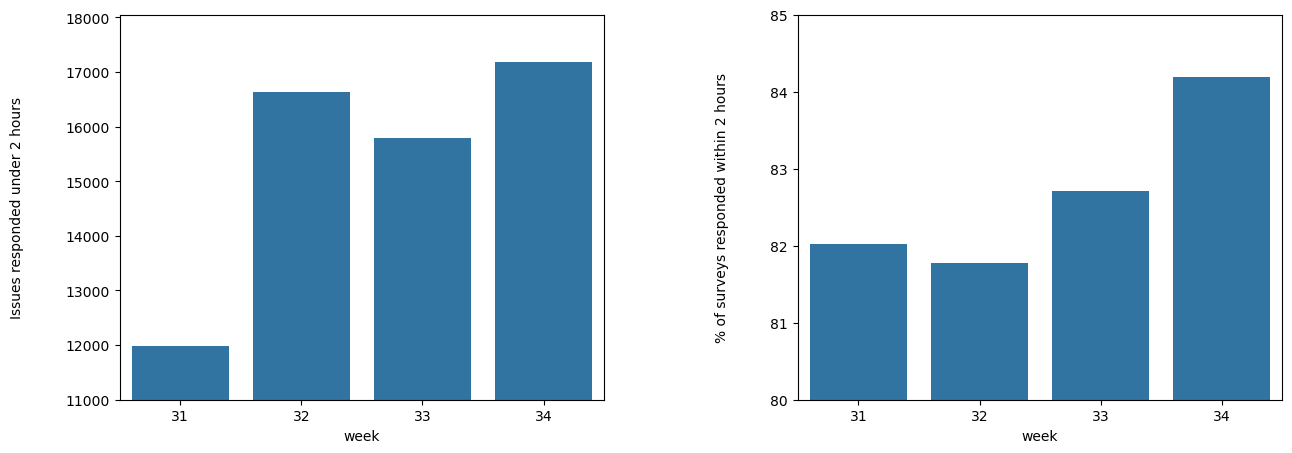

In [47]:
fig, axes = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'wspace': 0.4})
sns.barplot(data=responseTimeBreakdown, x='week', y='resolvedUnder2Hours', ax=axes[0])
sns.barplot(data=responseTimeBreakdown, x='week', y='Percent resolved', ax=axes[1])
axes[0].set_ylabel('Issues responded under 2 hours', labelpad=30)
axes[1].set_ylabel(f"% of surveys responded within 2 hours", labelpad=30)

axes[0].set_ylim(11000)
axes[1].set_ylim(80,85)



plt.show()